In [17]:
import numpy as np
import os
import matplotlib.pyplot as plt
#from scipy.misc import imread, imresize
#from imageio import imread #using instead of imread from scipy.misc
#from scipy.misc import imresize
from skimage.io import imread #using instead of imread from scipy.misc
from skimage.transform import resize #use resize instead of imresize
import datetime
import os

import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.regularizers import l2
from keras import optimizers
from tensorflow.python.keras.utils.data_utils import Sequence
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
#tf.set_random_seed(30)

In [3]:
#train_doc = np.random.permutation(open('/notebooks/storage/Final_data/Collated_training/train.csv').readlines())
#val_doc = np.random.permutation(open('/notebooks/storage/Final_data/Collated_training/val.csv').readlines())

train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())

batch_size = 20 #experiment with the batch size
print("Training data:" , len(train_doc))
print("Validation data:", len(val_doc))

Training data: 663
Validation data: 100


In [4]:
height = 120 # image width
width = 120 # image height
img_idx = np.arange(0, 30, 2) #create a list of image numbers you want to use for a particular video

In [5]:
classes = ['Thumbs up', 'Thumbs down','Left swipe', 'Right swipe', 'Stop']
print(classes)
num_classes = len(classes)
print(num_classes)

['Thumbs up', 'Thumbs down', 'Left swipe', 'Right swipe', 'Stop']
5


## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with img_idx, y,z and normalization such that you get high accuracy.

##### Starter Generator Logic

def generator(source_path, folder_list, batch_size):
    y = 100 # image width
    z = 100 # image height

    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = np.arange(0,30,2) #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size  # calculate the number of batches #no. of sequences/batch_size... #1 seq = 1 video... #eg: seq => 100/10 = 10
        print('Total Sequences :', num_batches * batch_size)
        x = len(img_idx)
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    #crop the images and resize them. Note that the images are of 2 different shape
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    if image.shape[1] == 160:
                        image = image[:, 20:140, :] # Cropping  20 px from the sides...  to make it a square image.

                    res_image = resize(image=image, output_shape=(y, z), anti_aliasing=True)

                    batch_data[folder,idx,:,:,0] = res_image[:,:,0] #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = res_image[:,:,1] #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = res_image[:,:,2] #normalise and feed in the image

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
        # write the code for the remaining data points which are left after full batches

#### Generator & Support Functions

In [6]:
def process_batch(source_path, folders_list, batch, batch_size, img_idx, height=120, width=120):
    num_images = len(img_idx)
    batch_data   = np.zeros((batch_size, num_images, height, width, 3)) # 3 is the number of channels RGB
    batch_labels = np.zeros((batch_size, 5)) # batch_labels is the one hot representation of the output

    for folder in range(batch_size): # iterate over the batch_size
        imgs = os.listdir(source_path+'/'+ folders_list[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
        for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
            image = imread(source_path+'/'+ folders_list[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

            #crop the images and resize them. Note that the images are of 2 different shape
            #and the conv3D will throw error if the inputs in a batch have different shapes
            h, w, c = image.shape
            if w == 160:
                image = image[: 20:140, :] #Crop Horizontal edges to make it a square image
            image = resize(image, (height, width), anti_aliasing=True)

            batch_data[folder,idx,:,:,0] = (image[...,0])/255 #normalise and feed in the image
            batch_data[folder,idx,:,:,1] = (image[...,1])/255 #normalise and feed in the image
            batch_data[folder,idx,:,:,2] = (image[...,2])/255 #normalise and feed in the image

        batch_labels[folder, int(folders_list[folder + (batch*batch_size)].strip().split(';')[2])] = 1

    yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

In [7]:
def gesture_generator(source_path, folder_list, batch_size, img_idx, height=120, width=120):
    #total_frames = 30
    #num_images = len(img_idx)
    while True:
        number_of_batches = len(folder_list)//batch_size # calculate the number of batches
        randomized_folders_list = np.random.permutation(folder_list)

        for batch in range(number_of_batches): # we iterate over the number of batches
            for batch_data, batch_labels in process_batch(source_path, randomized_folders_list, batch, batch_size, img_idx, height, width):
                yield batch_data, batch_labels

            # Remaining (would be < than the batch size) = total - (number_of_batches * batch_size)
            remaining_batch_size = len(folder_list) - (number_of_batches * batch_size)
            if (remaining_batch_size > 0):
                for batch_data, batch_labels in process_batch(source_path, randomized_folders_list, batch, remaining_batch_size, img_idx, height, width):
                    yield batch_data, batch_labels

In [8]:
def plot_loss_accuracy(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [9]:
def visualize_outputs(fit_data, epoch):
    acc = fit_data.history['categorical_accuracy']
    val_acc = fit_data.history['val_categorical_accuracy']

    loss = fit_data.history['loss']
    val_loss = fit_data.history['val_loss']

    epochs_range = range(epoch)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [10]:
t = np.random.permutation(train_doc)
nb = len(t)//batch_size
range(nb)

range(0, 33)

## Prepare a Model

### 1. Create a Conv3D + RNN (GRU)

import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.regularizers import l2
from keras import optimizers
from tensorflow.python.keras.utils.data_utils import Sequence

In [11]:
def prepare_conv3d_model():
    model = Sequential()
    model.add(Conv3D(32, (3,3,3), padding='same', input_shape=(len(img_idx), height, width, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(64, (3,3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(64, (3,3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.20))

    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    return model

In [12]:
def model_callbacks(curr_dt_time, save_folder_name):
    model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    save_file_path = save_folder_name + '/' + model_name + '/'
    if not os.path.exists(save_file_path):
        os.makedirs(save_file_path, mode=0o666)
    filepath = save_file_path + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
    #LR = # write the REducelronplateau code here
    #LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, fmin_lr=0.00001, verbose=1)
    #return [checkpoint, LR]
    return checkpoint

In [13]:
def get_steps_info(num_train_sequences, num_val_sequences, batch_size):
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1
    return steps_per_epoch, validation_steps

In [14]:
model_01 = prepare_conv3d_model()
optimizer = optimizers.Adam()
model_01.compile(optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model_01.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 15, 120, 120, 32   2624      
                             )                                   
                                                                 
 activation (Activation)     (None, 15, 120, 120, 32   0         
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 7, 60, 60, 32)     0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 7, 60, 60, 64)     55360     
                                                                 
 activation_1 (Activation)   (None, 7, 60, 60, 64)     0         
                                                        

In [15]:
height = 120 # image width
width = 120 # image height
img_idx = np.arange(0, 30, 2) #create a list of image numbers you want to use for a particular video
num_epochs = 15
LrPlateau_patience = 2
LrPlateau_mode = 'auto'
LrPlateau_factor = 0.1
LrPlateau_fmin_lr = 0.00001

In [18]:

curr_dt_time = datetime.datetime.now()
LR = ReduceLROnPlateau(monitor='val_loss',
                       factor=LrPlateau_factor,
                       patience=LrPlateau_patience,
                       fmin_lr=LrPlateau_fmin_lr, verbose=1)

callbacks_list = [model_callbacks(curr_dt_time, "d:\model_conv3D_1"), LR]
steps_per_epoch, validation_steps = get_steps_info(len(train_doc), len(val_doc), batch_size)

In [19]:
print('Epochs', num_epochs)
print('steps_per_epoch', steps_per_epoch)
print('validation_steps', validation_steps)

Epochs 15
steps_per_epoch 34
validation_steps 5


In [20]:
training_data_gen = gesture_generator('Project_data/train', train_doc, batch_size, img_idx, height, width)
validation_data_gen = gesture_generator('Project_data/val', val_doc, batch_size, img_idx, height, width)

In [21]:
#fit_generator is deprecated.. using model.fit with generator objects...

history = model_01.fit(x=training_data_gen, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                       callbacks=callbacks_list, validation_data=validation_data_gen,
                       validation_steps=validation_steps)

Epoch 1/15
34/34 [==============================] - ETA: 0s - loss: 2.8901 - categorical_accuracy: 0.2353
Epoch 1: saving model to d:\model_conv3D_1/model_init_2023-09-2922_03_02.244585\model-00001-2.89014-0.23529-1.62066-0.20000.h5
34/34 [==============================] - 201s 6s/step - loss: 2.8901 - categorical_accuracy: 0.2353 - val_loss: 1.6207 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 2/15


C:\Program Files\Python39\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


34/34 [==============================] - ETA: 0s - loss: 1.6314 - categorical_accuracy: 0.2583
Epoch 2: saving model to d:\model_conv3D_1/model_init_2023-09-2922_03_02.244585\model-00002-1.63136-0.25831-1.58360-0.25000.h5
34/34 [==============================] - 202s 6s/step - loss: 1.6314 - categorical_accuracy: 0.2583 - val_loss: 1.5836 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 3/15
34/34 [==============================] - ETA: 0s - loss: 1.6345 - categorical_accuracy: 0.2737
Epoch 3: saving model to d:\model_conv3D_1/model_init_2023-09-2922_03_02.244585\model-00003-1.63453-0.27366-1.56845-0.27000.h5
34/34 [==============================] - 213s 6s/step - loss: 1.6345 - categorical_accuracy: 0.2737 - val_loss: 1.5684 - val_categorical_accuracy: 0.2700 - lr: 0.0010
Epoch 4/15
34/34 [==============================] - ETA: 0s - loss: 1.5383 - categorical_accuracy: 0.3146
Epoch 4: saving model to d:\model_conv3D_1/model_init_2023-09-2922_03_02.244585\model-00004-1.53825-0.314

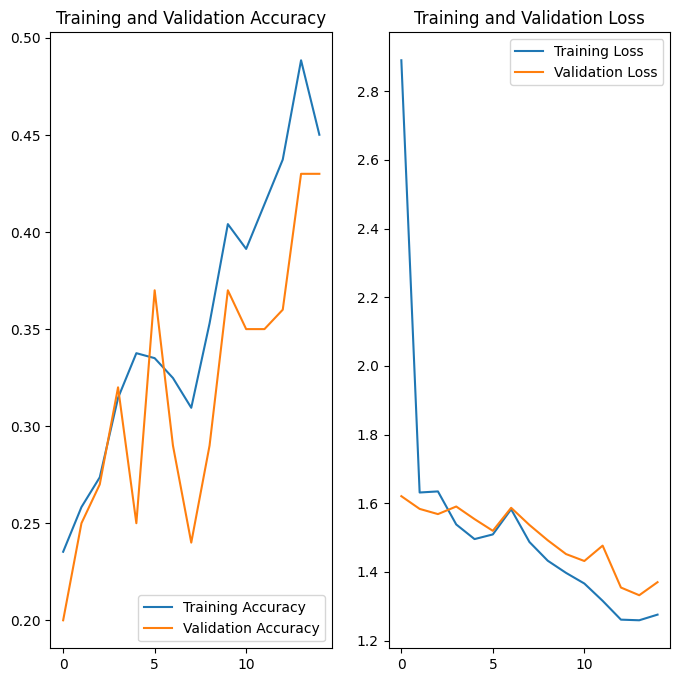

In [22]:
visualize_outputs(history, epoch=num_epochs)

len(train_doc)%batch_size

len(train_doc)

def process_batch(source_path, folders_list, batch, batch_size, img_idx, height=120, width=120):
    num_images = len(img_idx)
    batch_data   = np.zeros((batch_size, num_images, height, width, 3)) # 3 is the number of channels RGB
    batch_labels = np.zeros((batch_size, 5)) # batch_labels is the one hot representation of the output

    for folder in range(batch_size): # iterate over the batch_size
        imgs = os.listdir(source_path+'/'+ folders_list[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
        for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
            image = imread(source_path+'/'+ folders_list[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

            #crop the images and resize them. Note that the images are of 2 different shape
            #and the conv3D will throw error if the inputs in a batch have different shapes
            h, w, c = image.shape
            if w == 160:
                image = image[: 20:140, :] #Crop Horizontal edges to make it a square image
            image = resize(image, (height, width), anti_aliasing=True)

            batch_data[folder,idx,:,:,0] = (image[...,0])/255 #normalise and feed in the image
            batch_data[folder,idx,:,:,1] = (image[...,1])/255 #normalise and feed in the image
            batch_data[folder,idx,:,:,2] = (image[...,2])/255 #normalise and feed in the image

        batch_labels[folder, int(folders_list[folder + (batch*batch_size)].strip().split(';')[2])] = 1

    yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

In [ ]:

def gesture_generator_beta(source_path, folder_list, batch_size, img_idx, height=120, width=120):
    total_frames = 30
    #num_images = len(img_idx)
    while True:
        number_of_batches = len(folder_list)//batch_size # calculate the number of batches
        randomized_folders_list = np.random.permutation(folder_list)

        for batch in range(number_of_batches): # we iterate over the number of batches
            for batch_data, batch_labels in process_batch(source_path, randomized_folders_list, batch, batch_size, img_idx, height, width):
                yield batch_data, batch_labels

            # Remaining (would be < than the batch size) = total - (number_of_batches * batch_size)
            remaining_batch_size = len(folder_list) - (number_of_batches * batch_size)
            if (remaining_batch_size > 0):
                for batch_data, batch_labels in process_batch(source_path, randomized_folders_list, batch, remaining_batch_size, img_idx, height, width):
                    yield batch_data, batch_labels


training_data_gen = gesture_generator_beta('Project_data/train', train_doc, batch_size, img_idx, height, width)
validation_data_gen = gesture_generator_beta('Project_data/val', val_doc, batch_size, img_idx, height, width)

h2 = conv_3d_model.fit(x=training_data_gen, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                              callbacks=callbacks_list, validation_data=validation_data_gen,
                              validation_steps=validation_steps)

visualize_outputs(h2, epoch=num_epochs)